# Qiskit compatibility

This notebook provides an example of how to built circuits with Qiskit and run them on the Quokka via QASM scripts.


# Qiskit installation

The first step is to install qiskit. Installation instructions are available in the documentation for Qiskit here: https://qiskit.org/documentation/install.html.

In [ ]:
# install qiskit
!pip install qiskit~=0.20

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 3.8 MB/s eta 0:00:00


Obviously we need to import qiskit. But we will also need numpy later.

In [ ]:
import qiskit
import numpy as np
import requests
import os
import json

import warnings
warnings.filterwarnings('ignore')

# current Quokka address:
req_str_qasm = 'http://quokka1.quokkacomputing.com/qsim/qasm'


# Superdense coding

[Superdense coding](https://en.wikipedia.org/wiki/Superdense_coding) is a protocol that allows the tranmission of two classical bits of information using one qubit of information. Alice and Bob must first share and entangled pair of qubits. The circuit diagram of the protocol looks as follows. The top two bits are chosen by Alice and encoded in her qubit through $X$ and $Z$ gates. Bob then unentangles the two qubits and measures, revealing the bits Alice encoded.

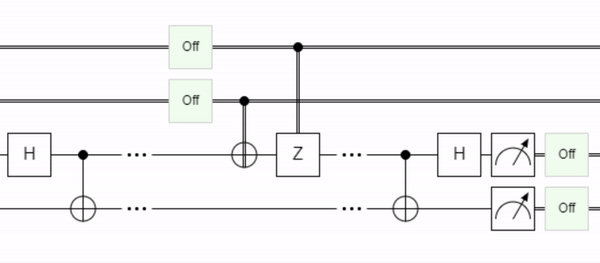

Let's get started. The first thing Alice and Bob need to do is create entanglement.

In [ ]:
# create cirquit
superdense = qiskit.QuantumCircuit(2,2)

print(superdense)

     
q_0: 
     
q_1: 
     
c: 2/
     


In [ ]:
superdense.h(0)
superdense.cx(0,1)


print(superdense)

     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
c: 2/══════════
               


Now Alice needs to encode her message. There are four possibilities.

If Alice wants to send
* 00, she does nothing;
* 01, she performs an $X$ gate;
* 10, she performs a $Z$ gate;
* 11, she performs $XZ$.

Let's say Alice choses 11.


In [ ]:
superdense.x(0)
superdense.z(0)

print(superdense)

     ┌───┐     ┌───┐┌───┐
q_0: ┤ H ├──■──┤ X ├┤ Z ├
     └───┘┌─┴─┐└───┘└───┘
q_1: ─────┤ X ├──────────
          └───┘          
c: 2/════════════════════
                         


Now Alice sends her qubit to Bob. Bob unentangles them.

In [ ]:
superdense.cx(0,1)
superdense.h(0)

print(superdense)

     ┌───┐     ┌───┐┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ X ├┤ Z ├──■──┤ H ├
     └───┘┌─┴─┐└───┘└───┘┌─┴─┐└───┘
q_1: ─────┤ X ├──────────┤ X ├─────
          └───┘          └───┘     
c: 2/══════════════════════════════
                                   


Finally Bob measures both qubits.

In [ ]:
superdense.measure(0,0)
superdense.measure(1,1)

print(superdense)

     ┌───┐     ┌───┐┌───┐     ┌───┐┌─┐
q_0: ┤ H ├──■──┤ X ├┤ Z ├──■──┤ H ├┤M├
     └───┘┌─┴─┐└───┘└───┘┌─┴─┐└┬─┬┘└╥┘
q_1: ─────┤ X ├──────────┤ X ├─┤M├──╫─
          └───┘          └───┘ └╥┘  ║ 
c: 2/═══════════════════════════╩═══╩═
                                1   0 


Let's simulate this circuit on the Quokka. First we convert to QASM.

In [ ]:
superdense.qasm(formatted = True, filename = 'qasm.qasm')
with open('qasm.qasm', 'r') as file:
    code = file.read()
print(code)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
x q[0];
z q[0];
cx q[0],q[1];
h q[0];
measure q[0] -> c[0];
measure q[1] -> c[1];

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
x q[0];
z q[0];
cx q[0],q[1];
h q[0];
measure q[0] -> c[0];
measure q[1] -> c[1];



Next, the Quokka requires a data structure which includes the QASM code and the number of runs of it to do. It will return a JSON object that contains some diagnostic information and the results of the measurement. In this case it should be "1 1".

In [ ]:
data = {
    'script': code,
    'count': 1,
    'state_vector': False
}

result = requests.post(req_str_qasm, json=data, verify=False)
json_obj = json.loads(result.content)

print(json_obj)

{'error': 'no error', 'error_code': 0, 'result': {'c': [[1, 1]]}}


Huzzah! Here's how to pull the results from the dictionary.

In [ ]:
bits = list(np.concatenate(list(json_obj['result'].values())).flat)

print(bits)

[1, 1]


Just double check that with IBM QASM simulator...

In [ ]:
backend = qiskit.BasicAer.get_backend('qasm_simulator')
message = qiskit.execute(superdense, backend, shots=1).result().get_counts()

print(message)

{'11': 1}
